In [0]:
# a = []
# while(1):
#     a.append('1')
# !pip install librosa --upgrade

In [3]:
import matplotlib.pyplot as plt
from IPython.display import Audio
import numpy as np 
import scipy
# import mir_eval
import seaborn
from librosa import * 
import librosa.display
import librosa
import math
import sklearn
from scipy.stats import iqr
import os
import pandas as pd
from os import listdir
from os.path import isfile, join

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


from google.colab import drive
drive.mount('/content/gdrive')
print(librosa.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
0.7.2


In [0]:
SAVEE_emoIndex = {
    "n" : 1 , 
    "h" : 3 ,
   "sa" : 4 ,
    "a" : 5 ,
    "f" : 6 ,
    "d" : 7 ,
   "su" : 8
}
label_emotion = {
    1 : "Neutral",
    2 : "Calm",
    3 : "Happy",
    4 : "Sad",
    5 : "Angry",
    6 : "Fearful",
    7 : "Disgust",
    8 : "Surprised"
}
# Ravdess actor: odd number is Male, Even number is female
ravdess_actor_m = ['Actor_01','Actor_03','Actor_05','Actor_07','Actor_09','Actor_11','Actor_13','Actor_15','Actor_17','Actor_19']
ravdess_actor_f = ['Actor_02','Actor_04','Actor_06','Actor_08','Actor_10','Actor_12']
ravdess_actor = ravdess_actor_m
ravdess_testactor_m = ['Actor_21','Actor_23']
ravdess_actor_test = ravdess_testactor_m

projectdir = "/content/gdrive/My Drive/ver/"
savee_path = projectdir+"dataset/SAVEE/"
ravdess_path = projectdir+"dataset/RAVDESS/"
NUMFEATURE = 64
N_MFCC = 64
HOPLENGTH = 512
SAMPLINGRATE = 16000

In [0]:
# Pass in array, return


def findInnerQuartile(input_list):    
    center = 0
    middle = float(len(input_list))/2
    if middle % 2 != 0:
        center = int(middle - .5)
    else:
        center = int(middle) 
    return center-int(NUMFEATURE/2) , center+ int(NUMFEATURE/2)

def scaleFeature(feature):
    x = StandardScaler().fit_transform(feature)
    # x = preprocessing.normalize(feature)
    return x

def featureReduction_PCA(data,n_comp=1):
    pca = PCA(n_components=n_comp)
    data = scaleFeature(data)
    x = pca.fit_transform(data)
    return np.array(x)

def featureReduction_TSNE(data,n_comp=2):
    x = StandardScaler().fit_transform(data)
    x = pd.DataFrame(x)
    
    tsne = TSNE(n_components=n_comp)
    x_tsne = tsne.fit_transform(x)
    
    return np.array(x_tsne[0])

def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

def ndarrayToFeatureVector(array):
    featureVector = []
    i=0
    while i < len(array[0]):
        avg = 0
        column = []
        for subarray in array:
            column.extend([subarray[i]])
        avg = np.mean(column)
        featureVector.extend([avg])
        i+=1
    return featureVector

def generateGeneralComponent(directory,file):
    y , sr = librosa.load(directory+file,sr=SAMPLINGRATE)
    
    #Data extraction
    rms = librosa.feature.rms(y=y) # rms  1 x 140 
    rms_delta = librosa.feature.delta(rms,order=1)#  rms delta 1 x 140
    rms_delta2 = librosa.feature.delta(rms,order=2)

    crossing_rate = librosa.feature.zero_crossing_rate(y=y) # crossing_rate  1 x 140
    crz_d = librosa.feature.delta(crossing_rate,order=1)

    chroma_mean = np.abs(np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T,axis=0))

    MFCC = librosa.feature.mfcc(y=y, sr=sr,n_mfcc=N_MFCC)
    mfcc_mean = np.mean(MFCC.T, axis=0)
    mfcc_delta = np.abs(librosa.feature.delta(MFCC,order=1))
    mfcc_delta2 = np.abs(librosa.feature.delta(MFCC,order=2))

    STFT = np.abs(librosa.stft(y=y))
    stft_delta = librosa.feature.delta(STFT,order=1)

    mel_mean = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T,axis=0)

    oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=HOPLENGTH)

    tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,hop_length=HOPLENGTH)

    # lpc = librosa.lpc(y,27)
    # lpc_delta = librosa.feature.delta(lpc,order=1)

    result = np.array([a*c for a,c in zip(rms_delta[0], crossing_rate[0])])

    #Data reduction/scaling - return 1D vector
    mfcc_result = featureReduction_PCA(MFCC).T[0]  # 140 x 1
    mfcc_delta = featureReduction_PCA(mfcc_delta).T[0] # 140 x 1
    mfcc_delta2 = featureReduction_PCA(mfcc_delta2).T[0] # 140 x 1
  
    rms = featureReduction_PCA(rms[0].reshape(-1,1)).T[0]
    rms_delta = featureReduction_PCA(rms_delta[0].reshape(-1,1)).T[0]
    rms_delta2 = featureReduction_PCA(rms_delta2[0].reshape(-1,1)).T[0]

    stft = featureReduction_PCA(STFT).T[0]
    stft_delta = featureReduction_PCA(stft_delta).T[0]

    mel_mean = featureReduction_PCA(mel_mean.reshape(-1,1)).T[0]

    crossing_rate = featureReduction_PCA(crossing_rate.reshape(-1,1),1).T[0]
    crz_d = featureReduction_PCA(crz_d.reshape(-1,1),1).T[0]

    chroma_mean = featureReduction_PCA(chroma_mean.reshape(-1,1)).T[0] 

    tempogram = featureReduction_PCA(tempogram).T[0] 

    # lpcpca = featureReduction_PCA(lpc.reshape(-1,1)).T[0]
    # lpc_delta = featureReduction_PCA(lpc_delta.reshape(-1,1)).T[0]
    #Data selection
    p25 , p75 = findInnerQuartile(result)
    featurevector = result[p25: p75]

    p25 , p75 = findInnerQuartile(rms)
    rmsv = rms[p25:p75]

    p25 , p75 = findInnerQuartile(rms_delta)
    rmsDELTA = rms_delta[p25:p75]

    p25,p75 = findInnerQuartile(rms_delta2)
    rmsDELTA2 = rms_delta2[p25:p75]

    p25,p75 = findInnerQuartile(stft)
    stft = stft[p25:p75]

    p25,p75 = findInnerQuartile(stft_delta)
    stft_delta = stft_delta[p25:p75]

    p25 , p75 = findInnerQuartile(mfcc_result)
    mfccv = mfcc_result[p25:p75]

    mfcc_mean = mfcc_mean

    p25 , p75 = findInnerQuartile(mfcc_delta)
    mfcc_deltav = mfcc_delta[p25:p75]

    p25 , p75 = findInnerQuartile(mfcc_delta2)
    mfcc_delta2v = mfcc_delta2[p25:p75]
    
    p25 , p75 = findInnerQuartile(mel_mean)
    mel_mean  = mel_mean[p25:p75]

    p25 , p75 = findInnerQuartile(crossing_rate)
    cross = crossing_rate[p25:p75]

    p25 , p75 = findInnerQuartile(crz_d)
    crz_d = crz_d[p25:p75]

    p25 , p75 = findInnerQuartile(chroma_mean)
    chroma_mean = chroma_mean[p25:p75]

    p25 , p75 = findInnerQuartile(tempogram)
    tempogram = tempogram[p25:p75]

    component =  {'FEATUREV' : featurevector
                    , 'STFT' : stft
                   , 'STFTD' : stft_delta
                     , 'LPC' : []
                     , 'LPCD' : []
                    , 'MFCC' : mfccv
                    , 'TEMPO': tempogram
                 , 'MFCCMEAN': mfcc_mean
                   , 'MFCCD' : mfcc_deltav
                  , 'MFCCDD' : mfcc_delta2v
               , 'ZEROCROSS' : cross
                   , 'ZCRD' : crz_d
                     , 'RMS' : rmsv
                    , 'RMSD' : rmsDELTA
                    , 'RMSDD': rmsDELTA2
                  , 'CHROMA' : chroma_mean
                 , 'MELMEAN' : mel_mean}
    
    return component

def createSAVEEComponent(directory,file):
    index = SAVEE_emoIndex[file[0:-6]]
    emotionv = [0,0,0,0,0,0,0,0]
    emotionv[index - 1] = 1
    emotionl = index - 1
    
    component = generateGeneralComponent(directory,file)
    component['LABELV'] = emotionv
    component['EMOTIONL'] = emotionl
    return component
 
def createRAVDESSComponent(directory,file):
    file_feature = file.split("-")
    emotionv = [0,0,0,0,0,0,0,0]
    emotionindex = int(file_feature[2])-1
    emotionl = emotionindex
    emotionv[emotionindex] = 1
    
    component = generateGeneralComponent(directory,file)
    component['LABELV'] = emotionv
    component['EMOTIONL'] = emotionl
    return component
    
    
def findEmotionIndex(vector):
    index = 1 
    for column in vector:
        if int(column) == 1:
            return index
        index = index + 1
    return 1

def findValueByKey(pool,key):
    for skey,value in pool.items():
        if skey == key:
            return value
    return 99
        
def combine(*arg):
    big = np.array([])
    for arr in arg:
        big = np.append(big,arr)
    return big


In [101]:
# Load train data
data = [dict() for x in range(8)]
files_RAVDESS = []
for actor in ravdess_actor:
    actorpath = ravdess_path + actor 
    files = (os.listdir(actorpath))
    for file in files:
      files_RAVDESS.append((actorpath,file))

# Load test data
testdata = [dict() for x in range(8)]
files_RAVDESS_test = []
for actor in ravdess_actor_test:
    actorpath = ravdess_path + actor 
    files = (os.listdir(actorpath))
    for file in files:
      files_RAVDESS_test.append((actorpath,file))

# Create component for train data
n_file = 0
for path,file in files_RAVDESS:
    component = createRAVDESSComponent(path + '/',file)
    data[int(component['EMOTIONL'])][file] = component
    n_file +=1

# Create component for test data
n_testfile = 0
for path,file in files_RAVDESS_test :
    component = createRAVDESSComponent(path + '/',file)
    testdata[int(component['EMOTIONL'])][file] = component
    n_testfile +=1


# files_SAVEE = []
# files = (os.listdir(savee_path))
# for file in files:
#   files_RAVDESS.append((savee_path,file))

# for path,file in files_SAVEE:
#     component = createSAVEEComponent(path + '/',file)
#     data[int(component['EMOTIONL'])][file] = component
print('All dataset imported')
print('Total train data : {0}'.format(n_file))
print('Total test data : {0}'.format(n_testfile))


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:235: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/usr/local/lib/python3.6/dist-packages/librosa/filters.py:235: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/usr/local/lib/python3.6/dist-packages/librosa/filters.py:235: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/usr/local/lib/python3.6/dist-packages/librosa/filters.py:235: UserWarning: Empty filters detected in mel 

All dataset imported
Total train data : 600
Total test data : 120


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:235: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/usr/local/lib/python3.6/dist-packages/librosa/filters.py:235: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


In [102]:
    # component =  {'FEATUREV' : featurevector
    #                 , 'STFT' : stft
    #                , 'STFTD' : stft_delta
    #                  , 'LPC' : lpcpca
    #                 , 'MFCC' : mfccv
    #                 , 'TEMPO': tempogram
    #              , 'MFCCMEAN': mfcc_mean
    #                , 'MFCCD' : mfcc_deltav
    #               , 'MFCCDD' : mfcc_delta2v
    #            , 'ZEROCROSS' : cross
    #                , 'ZCRD' : crz_d
    #                  , 'RMS' : rmsv
    #                 , 'RMSD' : rmsDELTA
    #                 , 'RMSDD': rmsDELTA2
    #               , 'CHROMA' : chroma_mean
    #              , 'MELMEAN' : mel_mean}

#priority : 
# component['ZEROCROSS'],component['MFCCMEAN'],component['RMSD']

lst = []
trainedprocessed = []
# Prepare train data 
# choosenemotion = [2,3,4,7]
choosenemotion = [0,2,3]
for x in choosenemotion:
  filenum = 0
  for readfile, component in data[x].items():
        featurevector = combine( component['ZEROCROSS'],component['MFCCMEAN'], component['RMSD'])
        lst.append((featurevector,component['LABELV']))
        trainedprocessed.append((file,component['LABELV']))
        filenum += 1
  print('Train : {0}:{1}'.format(label_emotion.get(x+1),filenum))


testlst=[]
for x in choosenemotion:
  testfilenum = 0
  for readfile, component in testdata[x].items():
        featurevector = combine( component['ZEROCROSS'],component['MFCCMEAN'], component['RMSD'])
        testlst.append((featurevector,component['LABELV']))
        testfilenum += 1
  print('Test : {0} : {1}'.format(label_emotion.get(x+1),testfilenum))


print('Total train data : {0}'.format(len(lst)))
print('Total test data : {0}'.format(len(testlst)))

Train : Neutral:40
Train : Happy:80
Train : Sad:80
Test : Neutral : 8
Test : Happy : 16
Test : Sad : 16
Total train data : 200
Total test data : 40


In [0]:
# testlst = []
# testprocessed = []
# for emotiondata in testdata:
#     for file, component in emotiondata.items():
#         testlst.append((combine(component['MFCCDD'], component['RMSDD'])        
#                     ,component['LABELV']))
#         testprocessed.append((file,component['EMOTIONL']))

In [0]:
# for x in range(8):
#     print('{0} : '.format(label_emotion.get(x+1)))
#     for file, component in data[x].items():      
#         print('\t {0}'.format(component['LABELV']))

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

def getOptimisedParameter(training_x,training_y):
    y_converted = []
    for label in training_y:
        y_converted.append(findEmotionIndex(label))

    model = RandomForestClassifier(n_estimators=10000)
    model = model.fit(training_x, training_y)
    sel = SelectFromModel(model, prefit=True,threshold=3.5e-3)


    # sffs = SFS(RandomForestClassifier(), 
    #        k_features=75, 
    #        forward=True, 
    #        floating=True, 
    #        scoring='accuracy',
    #        cv=7)
    # sffs = sffs.fit(training_x, y_converted)
    # importantIndex = sffs.k_feature_idx_
    # index = 0
    # importantIndex = []
    # for entry in importantIndex:
    #   if entry == True:
    #     importantIndex.append(index)
    #   index +=1

    # estimator = RandomForestClassifier()
    # model = RFECV(estimator=estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
    # model.fit(training_x, y_converted)
    # selector = RFE(estimator, model.n_features_, step=1)
    # sel = selector.fit(training_x, y_converted)

    # model = RandomForestRegressor()
    # model = model.fit(training_x, training_y)
    # sel = SelectFromModel(model, prefit=True)


    index = 0
    importantIndex = []
    for entry in sel.get_support():
      if entry == True:
        importantIndex.append(index)
      index +=1

    print('Number of feature : {0}'.format(len(importantIndex)))
    return len(importantIndex),importantIndex

def getOptimisedFeature(features,importantIndex):
    optimized = []
    for index in importantIndex:
        optimized.append(features[index])
    return np.asarray(optimized)

def optimizeFeatureData(data,importantIndex):
    optimizedDataset = []
    
    for entry in data:
        optimizedDataset.append(getOptimisedFeature(entry,importantIndex))
    return np.asarray(optimizedDataset)

def OptimiseDataSet(X,y,xtest=[],ytest=[]):
    if len(xtest) == 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
    else:
        X_train = X
        y_train =  y
        X_test =  xtest  
        y_test = ytest

    OPTNUMFEATURE, selectedindex = getOptimisedParameter(X_train,y_train)
    X_train = optimizeFeatureData(X_train,selectedindex)
    X_test = optimizeFeatureData(X_test,selectedindex)
    print('Number of selected feature : {0}'.format(OPTNUMFEATURE))
    return X_train, X_test, y_train, y_test
    

    
    

In [125]:
X, y = zip(*lst)
X = np.asarray(X)
y = np.asarray(y)
print(X.shape)


Xtest, ytest = zip(*testlst)
Xtest = np.asarray(Xtest)
ytest = np.asarray(ytest)

FVECTOR_SIZE = len(X[0])

X_train, X_test, y_train, y_test = OptimiseDataSet(X, y,Xtest,ytest)



(200, 192)
Number of feature : 134
Number of selected feature : 134


In [126]:
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((200, 134), (40, 134), (200, 8), (40, 8))

In [0]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import GridSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# # rf_random  = RandomizedSearchCV(estimator = regressor
# #                    , param_distributions = random_grid
# #                    , n_iter = 100
# #                    , cv = 3
# #                    , verbose=2
# #                    , random_state=42
# #                    , n_jobs = -1)


In [0]:
# regressor.fit(X_train, y_train)


In [0]:
# correct = 0
# incorrect =0
# unknown = 0
# for x in range(len(X_train)):
#     y_pred = regressor.predict([X_train[x]])
#     correctindex = findEmotionIndex(y_train[x])-1
#     if (y_pred[0].round()[correctindex] == 1 ):
#         correct += 1 
#     else:
#         incorrect += 1
#     # print('Entry #{0}'.format(x))
#     # print('\t Correct index : {0}'.format(correctindex))
#     # print('\t Predicted prob : {0}'.format(y_pred[0].round()[correctindex]))
# print('Correct : {0}'.format(correct))
# print('inCorrect : {0}'.format(incorrect))
# acc = correct/(correct + incorrect)
# print('Accuracy : {0} %'.format(round(acc*100)))
    
    

In [0]:
# #Decision tree
# from sklearn.tree import DecisionTreeClassifier
# random_grid = {'criterion': ['gini','entropy'],
#                'splitter': ['best','random'],
#                'max_depth': [8,16,24,32,64,128,256],
#                'min_samples_split': [2],
#                'min_samples_leaf': [2],
#                'max_features': [ len(X_train[0]),'auto', 'sqrt', 'log2'],
#                'random_state': [0,None],
#                'max_leaf_nodes': [8,16,32]
#                }

# # dt =  DecisionTreeClassifier()
# # dt_random  = RandomizedSearchCV(estimator = dt
# #                    , param_distributions = random_grid
# #                    , n_iter = 100
# #                    , cv = 3
# #                    , verbose=2
# #                    , random_state=42
# #                    , n_jobs = -1)
# # dt_random.fit(X_train, y_train)
# # print(dt_random.best_params_)


# # {'splitter': 'random'
# # , 'random_state': None
# #  , 'min_samples_split': 2
# #  , 'min_samples_leaf': 2
# #  , 'max_leaf_nodes': 32
# #  , 'max_features': 184
# #  , 'max_depth': 256
# #  , 'criterion': 'gini'}
# dtree = DecisionTreeClassifier(splitter='random'
#                             ,random_state=None
#                             ,min_samples_split=2
#                             ,min_samples_leaf=2
#                             ,max_leaf_nodes=32
#                             ,max_features='auto'
#                             ,max_depth=256
#                             ,criterion='gini'
#         )     
# dtree.fit(X_train, y_train)


In [0]:
# correct = 0
# incorrect =0
# unknown = 0
# predictions = dtree.predict(X_train)
# for x in range(len(predictions)):
#     correctindex = findEmotionIndex(y_train[x])-1
#     predictedProb = predictions[x].round()[correctindex]
#     if (predictedProb == 1 ):
#         correct += 1 
#     else:
#         incorrect += 1
#     # print('Entry #{0}'.format(x))
#     # print('\t Correct index : {0}'.format(correctindex))
#     # print('\t Predicted prob : {0}'.format(predictedProb))
# print('Correct : {0}'.format(correct))
# print('inCorrect : {0}'.format(incorrect))
# acc = correct/(correct + incorrect)
# print('Accuracy : {0} %'.format(round(acc*100)))
# #     print(y_pred[0])
       

In [0]:
# correct = 0
# incorrect =0
# unknown = 0
# predictions = dtree.predict(X_test)
# for x in range(len(predictions)):
#     correctindex = findEmotionIndex(y_test[x])-1
#     predictedProb = predictions[x].round()[correctindex]
#     if (predictedProb == 1 ):
#         correct += 1 
#     else:
#         incorrect += 1
#     # print('Entry #{0}'.format(x))
#     # print('\t Correct index : {0}'.format(correctindex))
#     # print('\t Predicted prob : {0}'.format(predictedProb))
# print('Correct : {0}'.format(correct))
# print('inCorrect : {0}'.format(incorrect))
# acc = correct/(correct + incorrect)
# print('Accuracy : {0} %'.format(round(acc*100)))
# #     print(y_pred[0])
       

In [127]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

X_trainer, X_tunner, y_trainer, y_tunner = train_test_split(X_train, y_train, test_size=0.4, random_state=0)


max_features = [X_train.shape[1],'auto']
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
n_estimators = [200,2000,10000]
depths  = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
random_grid = {'n_estimators': n_estimators,
                'warm_start' : [ False]
               }

# randomizeSearchCV
estimator =  RandomForestClassifier()
rt_random  = RandomizedSearchCV(estimator=estimator
                   , param_distributions=random_grid
                   ,scoring='accuracy'
                   ,n_jobs=1
                   ,n_iter=300
                   ,cv=5)
rt_random.fit(X_trainer, y_trainer)
bestparams = rt_random.best_params_

# GridSearchCV
# rt_grid = GridSearchCV(estimator=estimator
#                         , param_grid=random_grid
#                         , cv= 5)
# rt_grid.fit(X_tunner, y_tunner)
# bestparams = rt_grid.best_params_
# print(rt_random.best_params_)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 3 is smaller than n_iter=300. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [128]:
# {'warm_start': False
#  , 'random_state': None
#  , 'n_estimators': 400
#  , 'min_samples_split': 4
#  , 'min_samples_leaf': 4
#  , 'max_leaf_nodes': 16
#  , 'max_features': 54
#  , 'max_depth': 64
#  , 'criterion': 'entropy'+}
print(bestparams)
rforest = RandomForestClassifier(**bestparams)
# rforest = RandomForestClassifier()

{'warm_start': False, 'n_estimators': 200}


In [129]:

y_train_index = []
for label in y_train:
    y_train_index.append(findEmotionIndex(label))

y_test_index = []
for label in y_test:
    y_test_index.append(findEmotionIndex(label))
X_train.shape, y_train.shape


rforest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [58]:
from sklearn.metrics import roc_auc_score
# predict = rforest.predict(X_train)
print(y_train.shape)
rf_probs = rforest.predict_proba(X_train)
roc_value = roc_auc_score(y_train, rf_probs)

print('roc accuracy: {0}'.format(roc_value))

mdl_acc = rforest.score(X_train, y_train_index)
print('accuracy: {0}'.format(mdl_acc))

(320, 8)


ValueError: ignored

In [76]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score,average_precision_score
predictions = rforest.predict(X_test)
rf_probs = rforest.predict_proba(X_test)
roc_value = roc_auc_score(y_test, rf_probs)
print('roc accuracy: {0}'.format(roc_value))

mdl_acc = rforest.score(X_test, y_test_index)
print('model score: {0}'.format(mdl_acc))

avg_acc = average_precision_score(y_test, rf_probs)
print('average accuracy: {0}'.format(avg_acc))



ValueError: ignored

In [130]:
correct = 0
incorrect =0
unknown = 0
# print(X_test.shape)
predictions = rforest.predict(X_train)
# print(predictions)+
for x in range(len(predictions)):
    # print(y_test[x])
    correctindex = findEmotionIndex(y_train[x])-1

    if (predictions[x][correctindex] == 1 ):
        correct += 1 
    else:
        incorrect += 1
    # print('Entry #{0}'.format(x))
    # print('\t Correct : {0}'.format(correctindex))
    # print('\t Predicted : {0}'.format(predicted))
print('Correct : {0}'.format(correct))
print('inCorrect : {0}'.format(incorrect))
acc = correct/(correct + incorrect)
print('Accuracy : {0} %'.format(round(acc*100)))

Correct : 200
inCorrect : 0
Accuracy : 100 %


In [132]:
correct = 0
incorrect =0
unknown = 0
# print(X_test.shape)
predictions = rforest.predict(X_test)
# print(predictions)+
for x in range(len(predictions)):
    # print(y_test[x])
    correctindex = findEmotionIndex(y_test[x])-1

    if (predictions[x][correctindex] == 1 ):
        correct += 1 
    else:
        incorrect += 1
    # print('Entry #{0}'.format(x))
    # print('\t Correct : {0}'.format(correctindex))
    # print('\t Predicted : {0}'.format(predicted))
print('Correct : {0}'.format(correct))
print('inCorrect : {0}'.format(incorrect))
acc = correct/(correct + incorrect)
print('Accuracy : {0} %'.format(round(acc*100)))
    
    

Correct : 12
inCorrect : 28
Accuracy : 30 %


[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]]
['Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Happy', 'Neutral', 'Neutral', 'Neutral', 'Happy', 'Happy', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happ

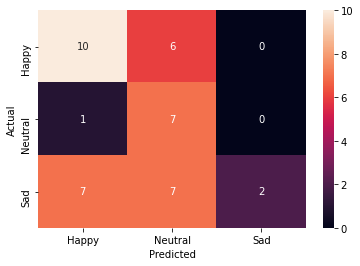

In [120]:
#Confusion matrix
# predictions = rforest.predict(X_test)
print(predictions)
predicted_emotion = []
for label in predictions:
    emo = label_emotion.get(findEmotionIndex(label))
    predicted_emotion.append(emo)
    # print('{0}:{1}'.format(label,emo))

true_emotion = []
for label in y_test:
    true_emotion.append(label_emotion.get(findEmotionIndex(label)))

print(predicted_emotion)
emotions = [*label_emotion.values()]

confusion_matrix = pd.crosstab(pd.Series(true_emotion)
                               , pd.Series(predicted_emotion)
                               , rownames=['Actual']
                               , colnames=['Predicted']
                               )
seaborn.heatmap(confusion_matrix, annot=True)